
# PIX2PIX
Google uses this for image to image translation.The idea behind night shot is this pix2pix



# Import libraries

In [0]:
import tensorflow as tf

In [0]:
import os
import time
import matplotlib.pyplot as plt
from IPython import display

In [0]:
import numpy as np

In [5]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')


30171136/30168306 [==============================] - 2s 0us/step


In [0]:
BUFFER_SIZE=400
BATCH_SIZE=1
IMG_WIDTH=256
IMG_HEIGHT=256

# Data augmentation

In [0]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    w= tf.shape(image)[1]
    w=w//2
    real_image=image[:, :w, :]
    input_image=image[:, w: ,:]
    
    input_image=tf.cast(input_image, tf.float32)
    real_image=tf.cast(real_image, tf.float32)
    return input_image,real_image

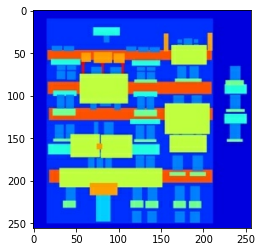

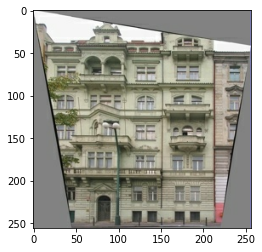

In [7]:
inp, re = load(PATH+'train/100.jpg')
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

In [0]:
def resize(input_image, real_image,height,width):
    input_image= tf.image.resize(input_image,[height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image= tf.image.resize(real_image,[height, width],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [0]:
def random_crop(input_image, real_image):
    stacked_image=tf.stack([input_image,real_image], axis=0)
    cropped_image=tf.image.random_crop(stacked_image, size=[2,IMG_HEIGHT,IMG_WIDTH,3])
    
    return cropped_image[0],cropped_image[1]

In [0]:
def standardize(input_image,real_image):
    input_image=(input_image-127.5)/127.5
    real_image=(real_image-127.5)/127.5
    
    return input_image, real_image

In [0]:
@tf.function()
def random_jitter(input_image, real_image):
    input_image,real_image = resize(input_image, real_image, 286, 286)
    input_image,real_image = random_crop(input_image, real_image)
    
    #if we apply random flip then we need to stack up the image or else not
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    
    return input_image,real_image

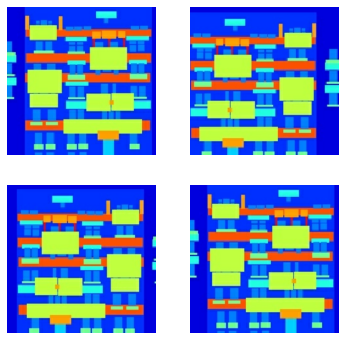

In [12]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp,rj_out=random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()


In [0]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = standardize(input_image, real_image)

  return input_image, real_image


In [0]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = standardize(input_image, real_image)

  return input_image, real_image


In [0]:
train_dataset = tf.data.Dataset.list_files(PATH+"train/*.jpg")
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)

In [0]:
test_dataset = tf.data.Dataset.list_files(PATH+"test/*.jpg")
test_dataset = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Bulid the Generator

In [0]:
OUTPUT_CHANNELS=3

In [0]:
def Downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


In [0]:
def Upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [0]:
def Generator():
    inputs=tf.keras.layers.Input(shape=[256,256,3])
    
    down_sample =[
        Downsample(64, 4, False),
        Downsample(128, 4),
        Downsample(256, 4),
        Downsample(512, 4),
        Downsample(512, 4),
        Downsample(512, 4),
        Downsample(512, 4),
        Downsample(512, 4),
        
    ]
    up_stack = [
        Upsample(512, 4, apply_dropout=True),
        Upsample(512, 4, apply_dropout=True),
        Upsample(512, 4, apply_dropout=True),
        Upsample(512, 4),
        Upsample(256, 4),
        Upsample(128, 4),
        Upsample(64, 4),
    ]
    initializer=tf.random_normal_initializer(0., 0.02)
    last=tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                        strides=2,
                                        padding="same",
                                        kernel_initializer=initializer,
                                        activation="tanh")
    
    x=inputs
    #Downsampling through the model
    skips =[]
    for down in down_sample:
        x=down(x)
        skips.append(x)
    skips =reversed(skips[:-1])
    
    #Upsampling
    for up,skip in zip(up_stack,skips):
        x=up(x)
        x=tf.keras.layers.Concatenate()([x,skip])
    x=last(x)
    
    return tf.keras.Model(inputs,x)
        

In [0]:
generator=Generator()

In [22]:
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  525312      sequential_1[0][0]               
______________________________________________________________________________________________

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


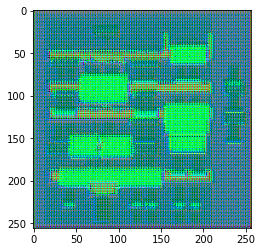

In [23]:
gen_output = generator(tf.expand_dims(inp,axis=0), training=False)
plt.imshow(gen_output[0])


# Generator Loss

# D(G(z))+lambda*(y-G(z)){l1}

In [0]:
LAMBDA=100

In [0]:
def generator_loss(dis_gen_out,gen_out,ori_out):
    loss=loss_object(tf.ones_like(dis_gen_out),dis_gen_out)
    
    #L1
    l1_loss=tf.reduce_mean(tf.abs(ori_out-gen_out))
    total_gan_loss=loss+(LAMBDA*l1_loss)
    return total_gan_loss,loss

# Discriminator

# it will be a basic patchGAN

In [0]:
def Discriminator():
    initializer= tf.random_normal_initializer(0.,0.02)
    inp=tf.keras.layers.Input(shape=[256,256,3], name="input_image")
    tar=tf.keras.layers.Input(shape=[256,256,3],name="target_image")
    
    x=tf.keras.layers.concatenate([inp,tar])
    down1 = Downsample(64,4,False)(x)
    down2 = Downsample(128,4)(down1)
    down3 = Downsample(128,4)(down2)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4,strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu= tf.keras.layers.ZeroPadding2D()(batchnorm1)
    
    last = tf.keras.layers.Conv2D(1, 4, strides=1,kernel_initializer=initializer)(leaky_relu)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [0]:
discriminator = Discriminator()



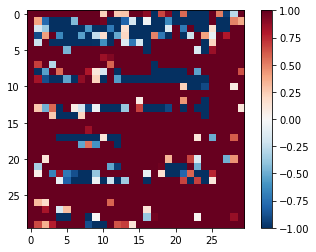

In [28]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()


In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


# Discriminator loss

# =log(D(z))+log(1-D(G(z)))

In [0]:
def discriminator_loss(dis_out,dis_gen_out):
    lossd=loss_object(tf.ones_like(dis_out),dis_out)
    lossg=loss_object(tf.zeros_like(dis_gen_out),dis_gen_out)
    tloss=lossd+lossg
    return tloss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [0]:
def generated_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
    plt.savefig("image{}".format(i))
  plt.show()
  


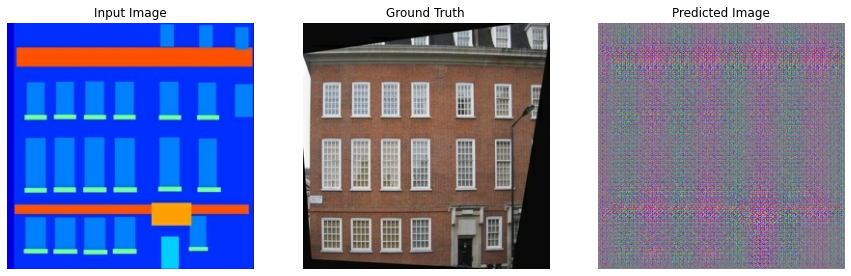

In [34]:
for example_input, example_target in test_dataset.take(1):
  generated_images(generator, example_input, example_target)


# training

In [0]:
epochs=400
gen_gan_loss=[]
dis_loss=[]
c="#"

In [0]:
@tf.function
def train_step(input_image,target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        gan_out=generator(input_image,training=True)
        dis_real_out=discriminator([input_image,target],training=True)
        dis_gan_out=discriminator([gan_out,target],training=True)
        
        gen_total_loss,lol=generator_loss(dis_gan_out,gan_out,target)
        disc_loss=discriminator_loss(dis_real_out,dis_gan_out)
        
    generator_gradients= gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients= dis_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
    
    return gen_total_loss,disc_loss

# We checked the number of batch to be 399

In [0]:
import math

In [0]:
def fit(train_ds,epochs):
    for epoch in range(epochs):
        start=time.time()
        print("EPOCHS::{}".format(epoch+1),end="")
        for n,(inp,tar) in train_ds.enumerate():
            genl,disl=train_step(inp,tar)
            gen_gan_loss.append(genl)
            dis_loss.append(disl)
            percentage=(n/399)*10
        print("GENERATOR LOSS::{} DISCRIMINATOR LOSS::{},TIME{}".format(tf.reduce_mean(np.asarray(genl)),tf.reduce_mean(np.asarray(disl)),time.time()-start))
        if ((epoch+1)%50)==0:
          checkpoint.save(file_prefix=checkpoint_prefix)
        print()


In [49]:
fit(train_dataset,400)

EPOCHS::1GENERATOR LOSS::36.38470458984375 DISCRIMINATOR LOSS::0.0016172751784324646,TIME21.805811405181885

EPOCHS::2GENERATOR LOSS::52.475738525390625 DISCRIMINATOR LOSS::0.00010274051601300016,TIME21.731690168380737

EPOCHS::3GENERATOR LOSS::49.934566497802734 DISCRIMINATOR LOSS::7.863318751333281e-05,TIME21.752038955688477

EPOCHS::4GENERATOR LOSS::46.37464141845703 DISCRIMINATOR LOSS::0.002458543749526143,TIME21.702032566070557

EPOCHS::5GENERATOR LOSS::43.31513595581055 DISCRIMINATOR LOSS::6.942175969015807e-05,TIME21.754501581192017

EPOCHS::6GENERATOR LOSS::33.465972900390625 DISCRIMINATOR LOSS::4.9874863179866225e-05,TIME21.727283716201782

EPOCHS::7GENERATOR LOSS::37.527854919433594 DISCRIMINATOR LOSS::0.00010394748096587136,TIME21.764276027679443

EPOCHS::8GENERATOR LOSS::35.691795349121094 DISCRIMINATOR LOSS::2.786740878946148e-05,TIME21.76075577735901

EPOCHS::9GENERATOR LOSS::33.28049850463867 DISCRIMINATOR LOSS::5.218989826971665e-05,TIME21.82547354698181

EPOCHS::10GENE

In [50]:
  checkpoint.restore(tf.train.latest_checkpoint("/content/training_checkpoints"))

Text(0, 0.5, 'LOSS')

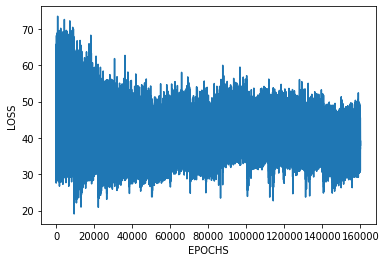

In [51]:
plt.plot(gen_gan_loss)
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")

Text(0, 0.5, 'LOSS')

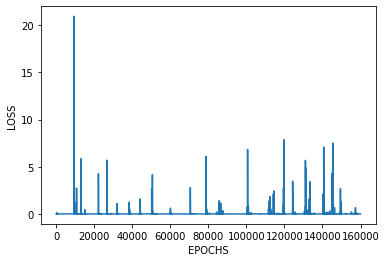

In [52]:
plt.plot(dis_loss)
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")

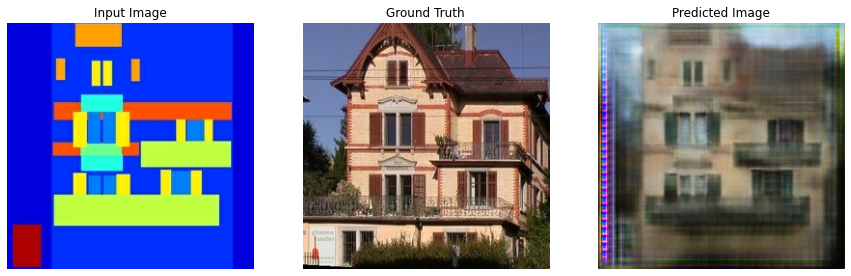

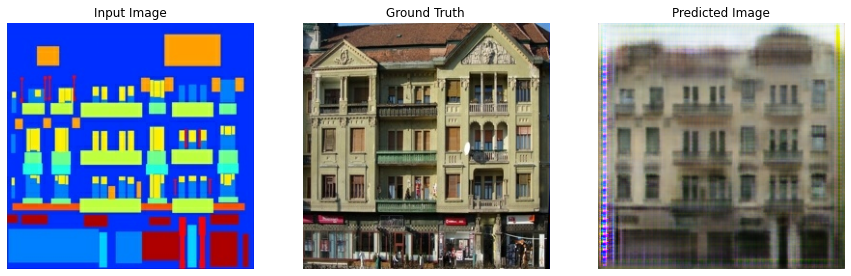

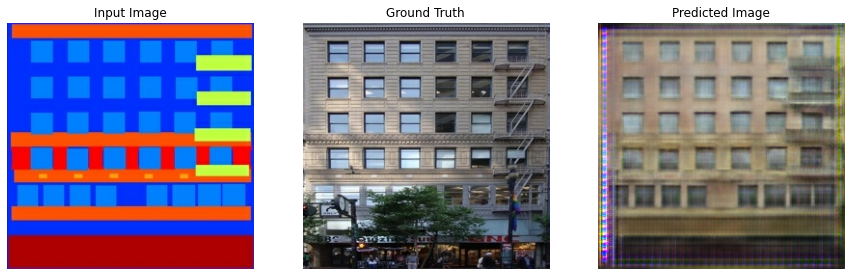

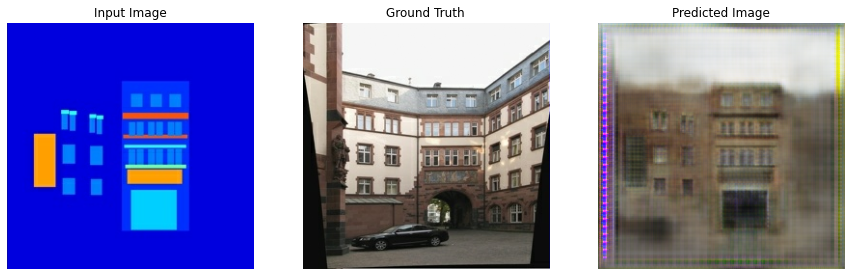

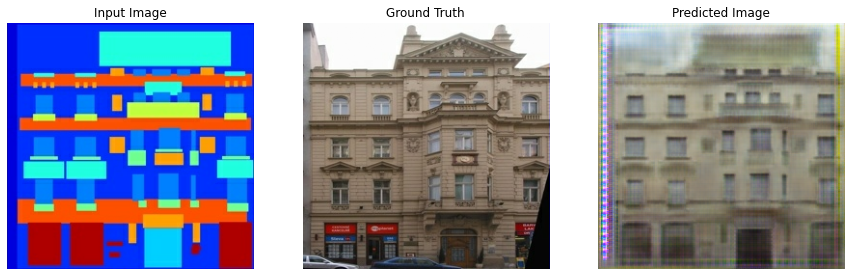

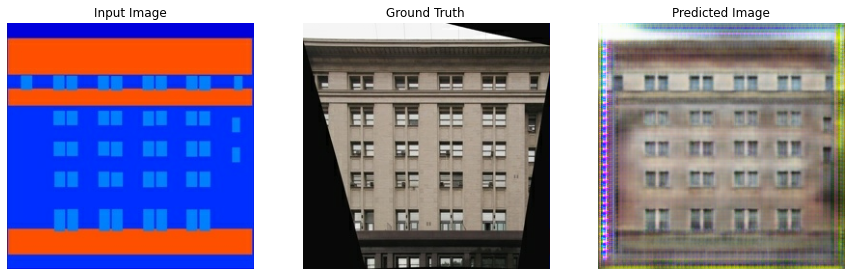

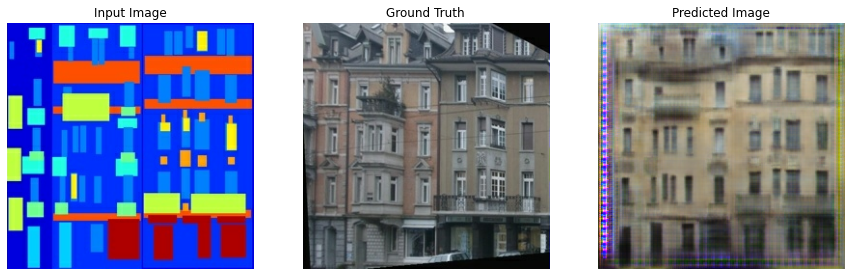

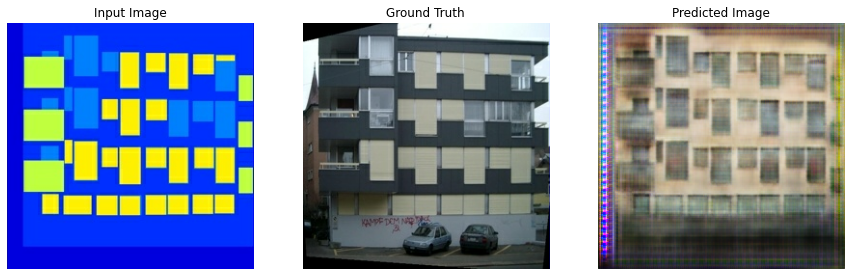

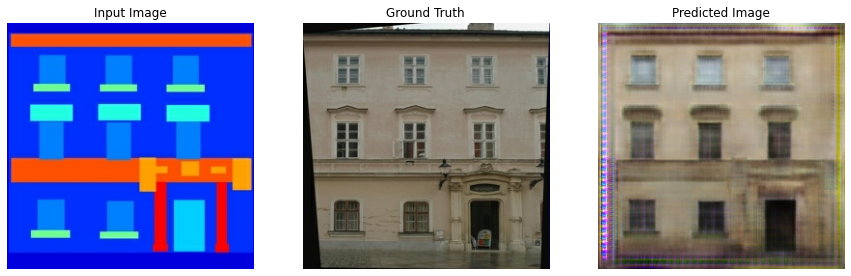

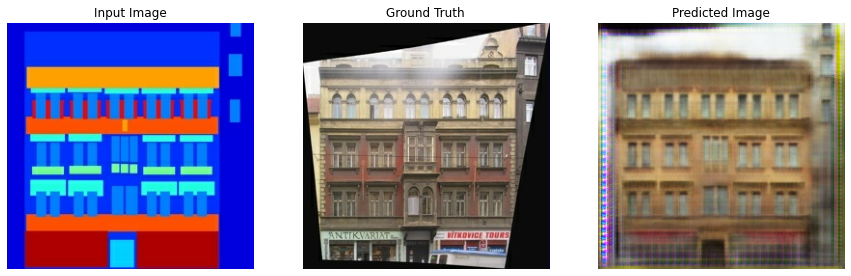

In [58]:
for example_input, example_target in test_dataset.take(10):
  generated_images(generator, example_input, example_target)


In [0]:
!zip -r training.zip /content/training_checkpoints

updating: content/training_checkpoints/ (stored 0%)
  adding: content/training_checkpoints/ckpt-5.index (deflated 80%)
  adding: content/training_checkpoints/ckpt-2.data-00000-of-00002 (deflated 89%)
  adding: content/training_checkpoints/ckpt-7.data-00000-of-00002 (deflated 89%)
  adding: content/training_checkpoints/ckpt-8.data-00001-of-00002 (deflated 22%)
  adding: content/training_checkpoints/ckpt-3.index (deflated 80%)
  adding: content/training_checkpoints/ckpt-4.index (deflated 80%)
  adding: content/training_checkpoints/ckpt-7.index (deflated 80%)
  adding: content/training_checkpoints/ckpt-4.data-00001-of-00002